# PLS Regression
I'm following this paper: <https://www.sciencedirect.com/science/article/pii/S1878929316301074?via%3Dihub>

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [61]:
from common.data import get_data

X, Y, demographics = get_data()
ages, sexes = demographics['Age'], demographics['Sex']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Sex: {sexes.shape}')

X: (594, 34716) | Y: 16 | Age: (594,) | Sex: (594,)


In [62]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (594,)


## Feature selection

### Age Binning

In [41]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 0 Range: 6.03 -> 8.98
Bin 1 Range: 9.04 -> 11.96
Bin 2 Range: 12.03 -> 15.98
---
Bin 0 Range: 53.00 -> 141.00
Bin 1 Range: 51.00 -> 141.00
Bin 2 Range: 47.00 -> 147.00
---
Bin 1: (185, 34716) | Bin 2: (231, 34716) | Bin 3: (178, 34716)


## PLS Regression Model

In [10]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_validate, permutation_test_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

### Set up the model pipeline, metrics, and cross-validation approach

In [67]:
def regression_scorer(reg, X, y):
#     y_pred = reg.predict(X)
    y_pred = reg.predict(X)[:, 0]
    
    return stats.pearsonr(y, y_pred)[0]

# estimators = [StandardScaler(), DummyRegressor(strategy="mean")]
estimators = [StandardScaler(), PLSRegression(n_components=4)]
pipe = make_pipeline(*estimators)

scoring = ['train_score', 'test_score']
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=251183)

### Train and test the pipeline on the metrics

In [ ]:
%%time
# X_cv = bin_3[0]
# y_cv = bin_3[1]
X_cv = X
y_cv = y

scores = cross_validate(pipe, X_cv, y_cv, cv=rkf, scoring=regression_scorer, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)

coefs = [estimator['plsregression'].coef_ for estimator in scores['estimator']]
avg_coef = np.mean(coefs, axis=0)[:, 0]

print(f'Target: {selected_target}')
for metric in scoring:
    metric_values = scores[metric]
    print(f'Avg {metric}: {np.mean(metric_values):.2f}')

In [ ]:
%%time
# X_cv = bin_3[0]
# y_cv = bin_3[1]
X_cv = X
y_cv = y

score, permutation_scores, pvalue = permutation_test_score(
    pipe, X_cv, y_cv, cv=rkf, scoring=regression_scorer, n_permutations=100, n_jobs=-1)

print(f'Target: {selected_target}')
print(f'Score: {score} | p-value: {pvalue}')

In [26]:
from common.paths import PLS_WEIGHTS

np.save(PLS_WEIGHTS, avg_coef)

## Analyze PLS Coefficients

### Plot

(264,) (264,)
[[ 32  14  56]
 [-18 -76 -24]
 [-10  -2  42]
 [  5  23  37]
 [ -8  48  23]
 [  0 -15  47]
 [-16  29  53]
 [-29 -43  61]
 [ 31  56  14]
 [-11  26  25]] [0.54652292 0.55590578 0.58247092 0.58599178 0.65889669 0.61792489
 0.79029503 0.72268657 0.70438368 1.        ]
[[-55 -40  14]
 [-42 -74   0]
 [ 33 -12 -34]
 [-46  31 -13]
 [ 33 -53  44]
 [ 29 -77  25]
 [-56 -13 -10]
 [-49 -42   1]
 [ 65 -24 -19]
 [ 51 -29  -4]] [0.63402112 0.68103181 0.73210149 0.6899601  0.6925454  0.80676884
 1.         0.87589462 0.8580287  0.87734981]


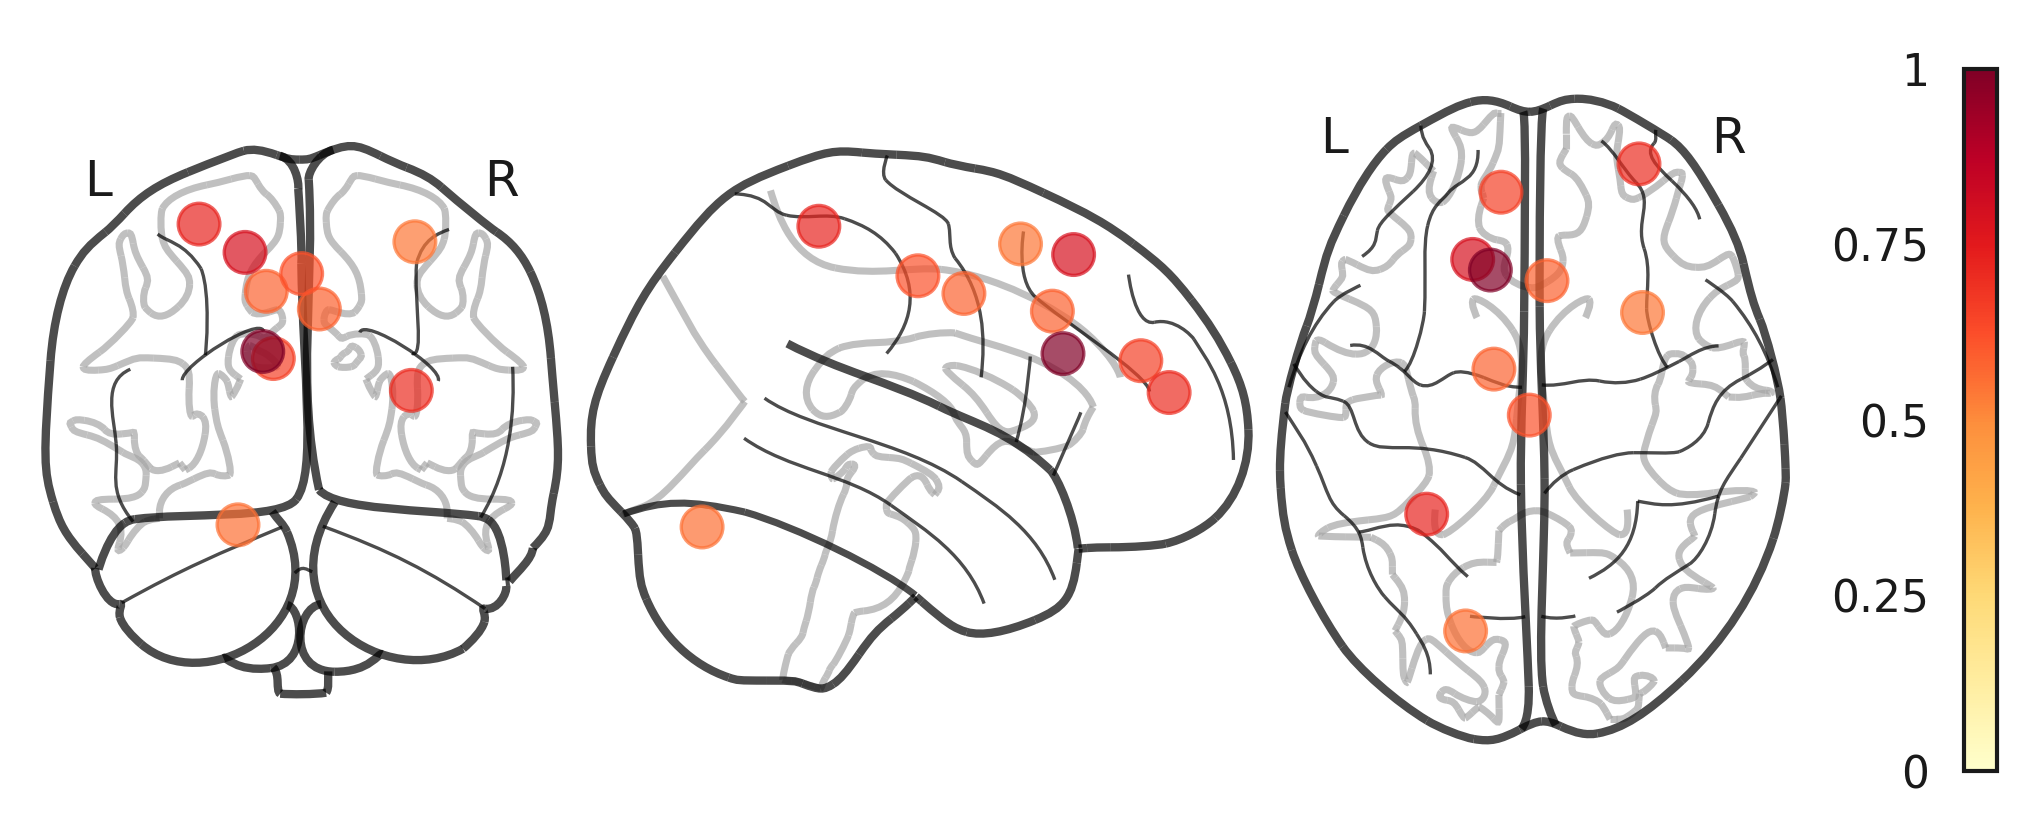

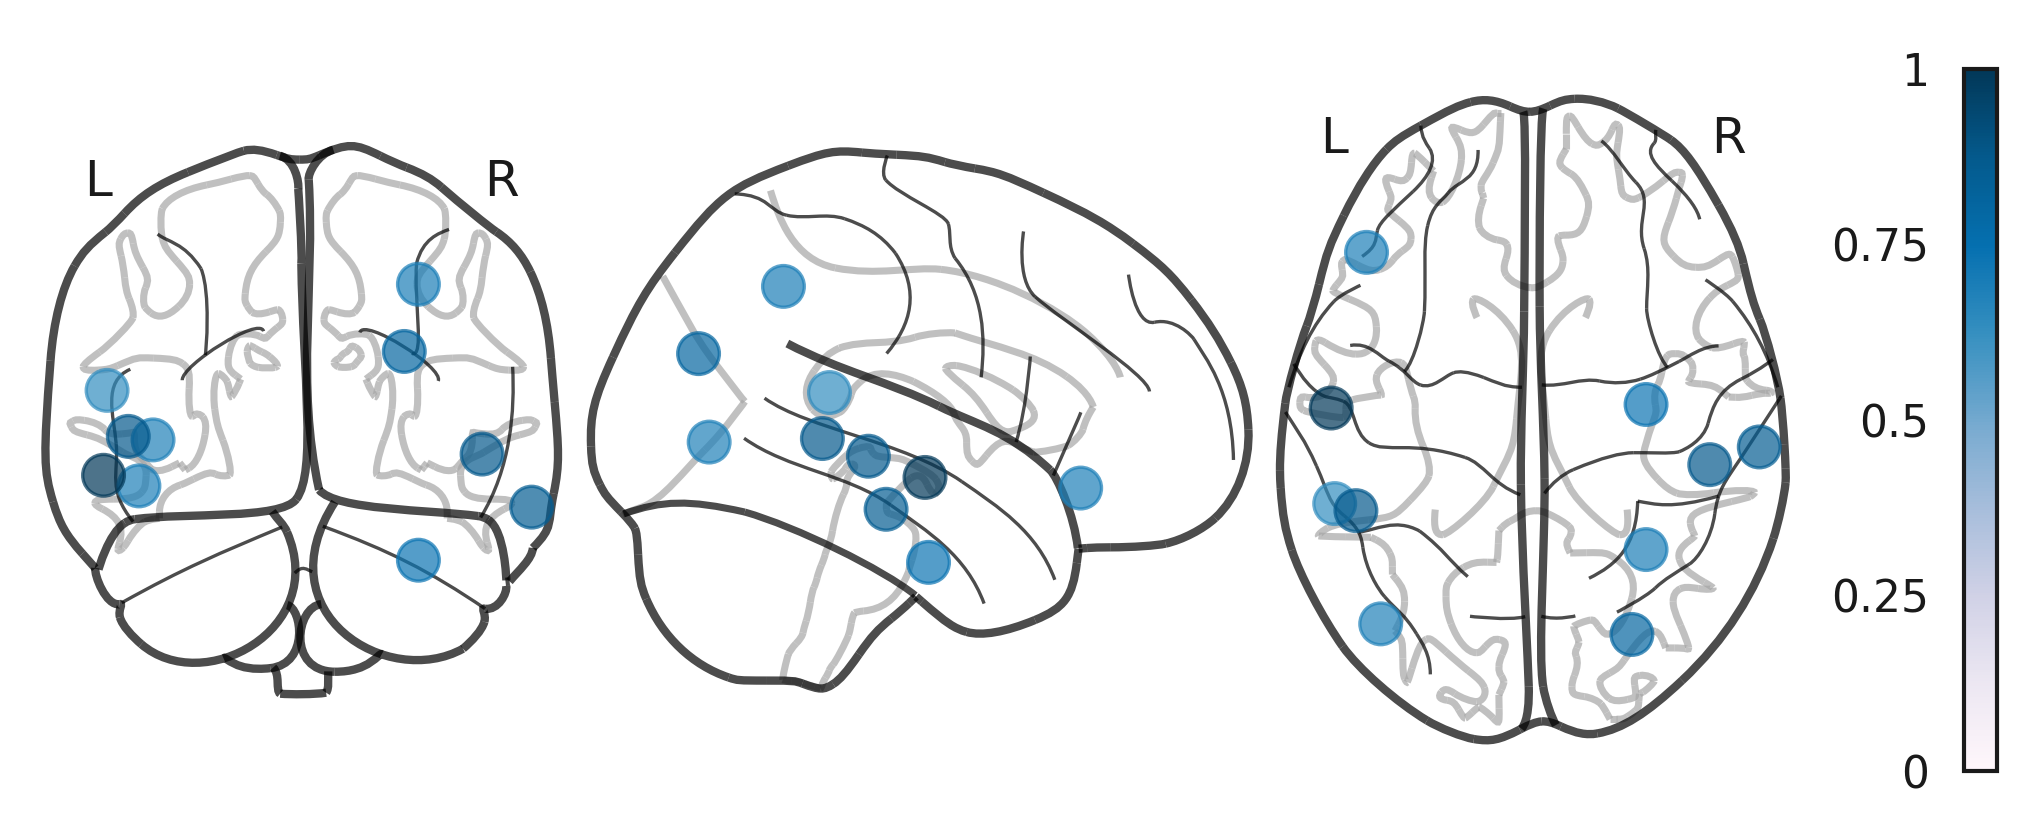

In [21]:
from nilearn import plotting, datasets
from common.calculation import get_k_argmax
from common.plotting import create_power_fc_matrix, convert_fc_to_node_strength

power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
matrix = create_power_fc_matrix(pls_coef)

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(matrix, 0, matrix.max())
negative_edges = np.clip(matrix, matrix.min(), 0)

# calculate strength for positive edges
node_strength_positive = convert_fc_to_node_strength(positive_edges)

# calculate strength for negative edges
node_strength_negative = convert_fc_to_node_strength(negative_edges)

print(node_strength_positive.shape, node_strength_negative.shape)
top_pos_nodes = get_k_argmax(node_strength_positive, 10)
top_neg_nodes = get_k_argmax(node_strength_negative, 10)

print(coords[top_pos_nodes], node_strength_positive[top_pos_nodes])
print(coords[top_neg_nodes], node_strength_negative[top_neg_nodes])

plotting.plot_markers(node_strength_positive[top_pos_nodes], coords[top_pos_nodes],
                      node_vmin=0, node_vmax=1, node_cmap="YlOrRd")
plotting.plot_markers(node_strength_negative[top_neg_nodes], coords[top_neg_nodes],
                      node_vmin=0, node_vmax=1, node_cmap="PuBu")

### Compare ages

In [36]:
from common.calculation import (
    calc_cosine_similarity, calc_norm_euclidean, compare_age_similarity)
from common.plotting import plot_age_comparisons

In [37]:
all_ages = mi.inverse_transform(avg_coef.T)[0]

In [41]:
bin_1 = mi_bin_1.inverse_transform(avg_coef.T)[0]

In [43]:
bin_2 = mi_bin_2.inverse_transform(avg_coef.T)[0]

In [45]:
bin_3 = mi_bin_3.inverse_transform(avg_coef.T)[0]

In [56]:
all_ages_s, bin_1_s, bin_2_s, bin_3_s = np.clip(all_ages, np.min(all_ages), 0), np.clip(bin_1, np.min(bin_1), 0), np.clip(bin_2, np.min(bin_2), 0), np.clip(bin_3, np.min(bin_3), 0)

[[1.         0.10837503 0.07464222 0.02468051]
 [0.10837503 1.         0.03270236 0.01762623]
 [0.07464222 0.03270236 1.         0.03451587]
 [0.02468051 0.01762623 0.03451587 1.        ]]


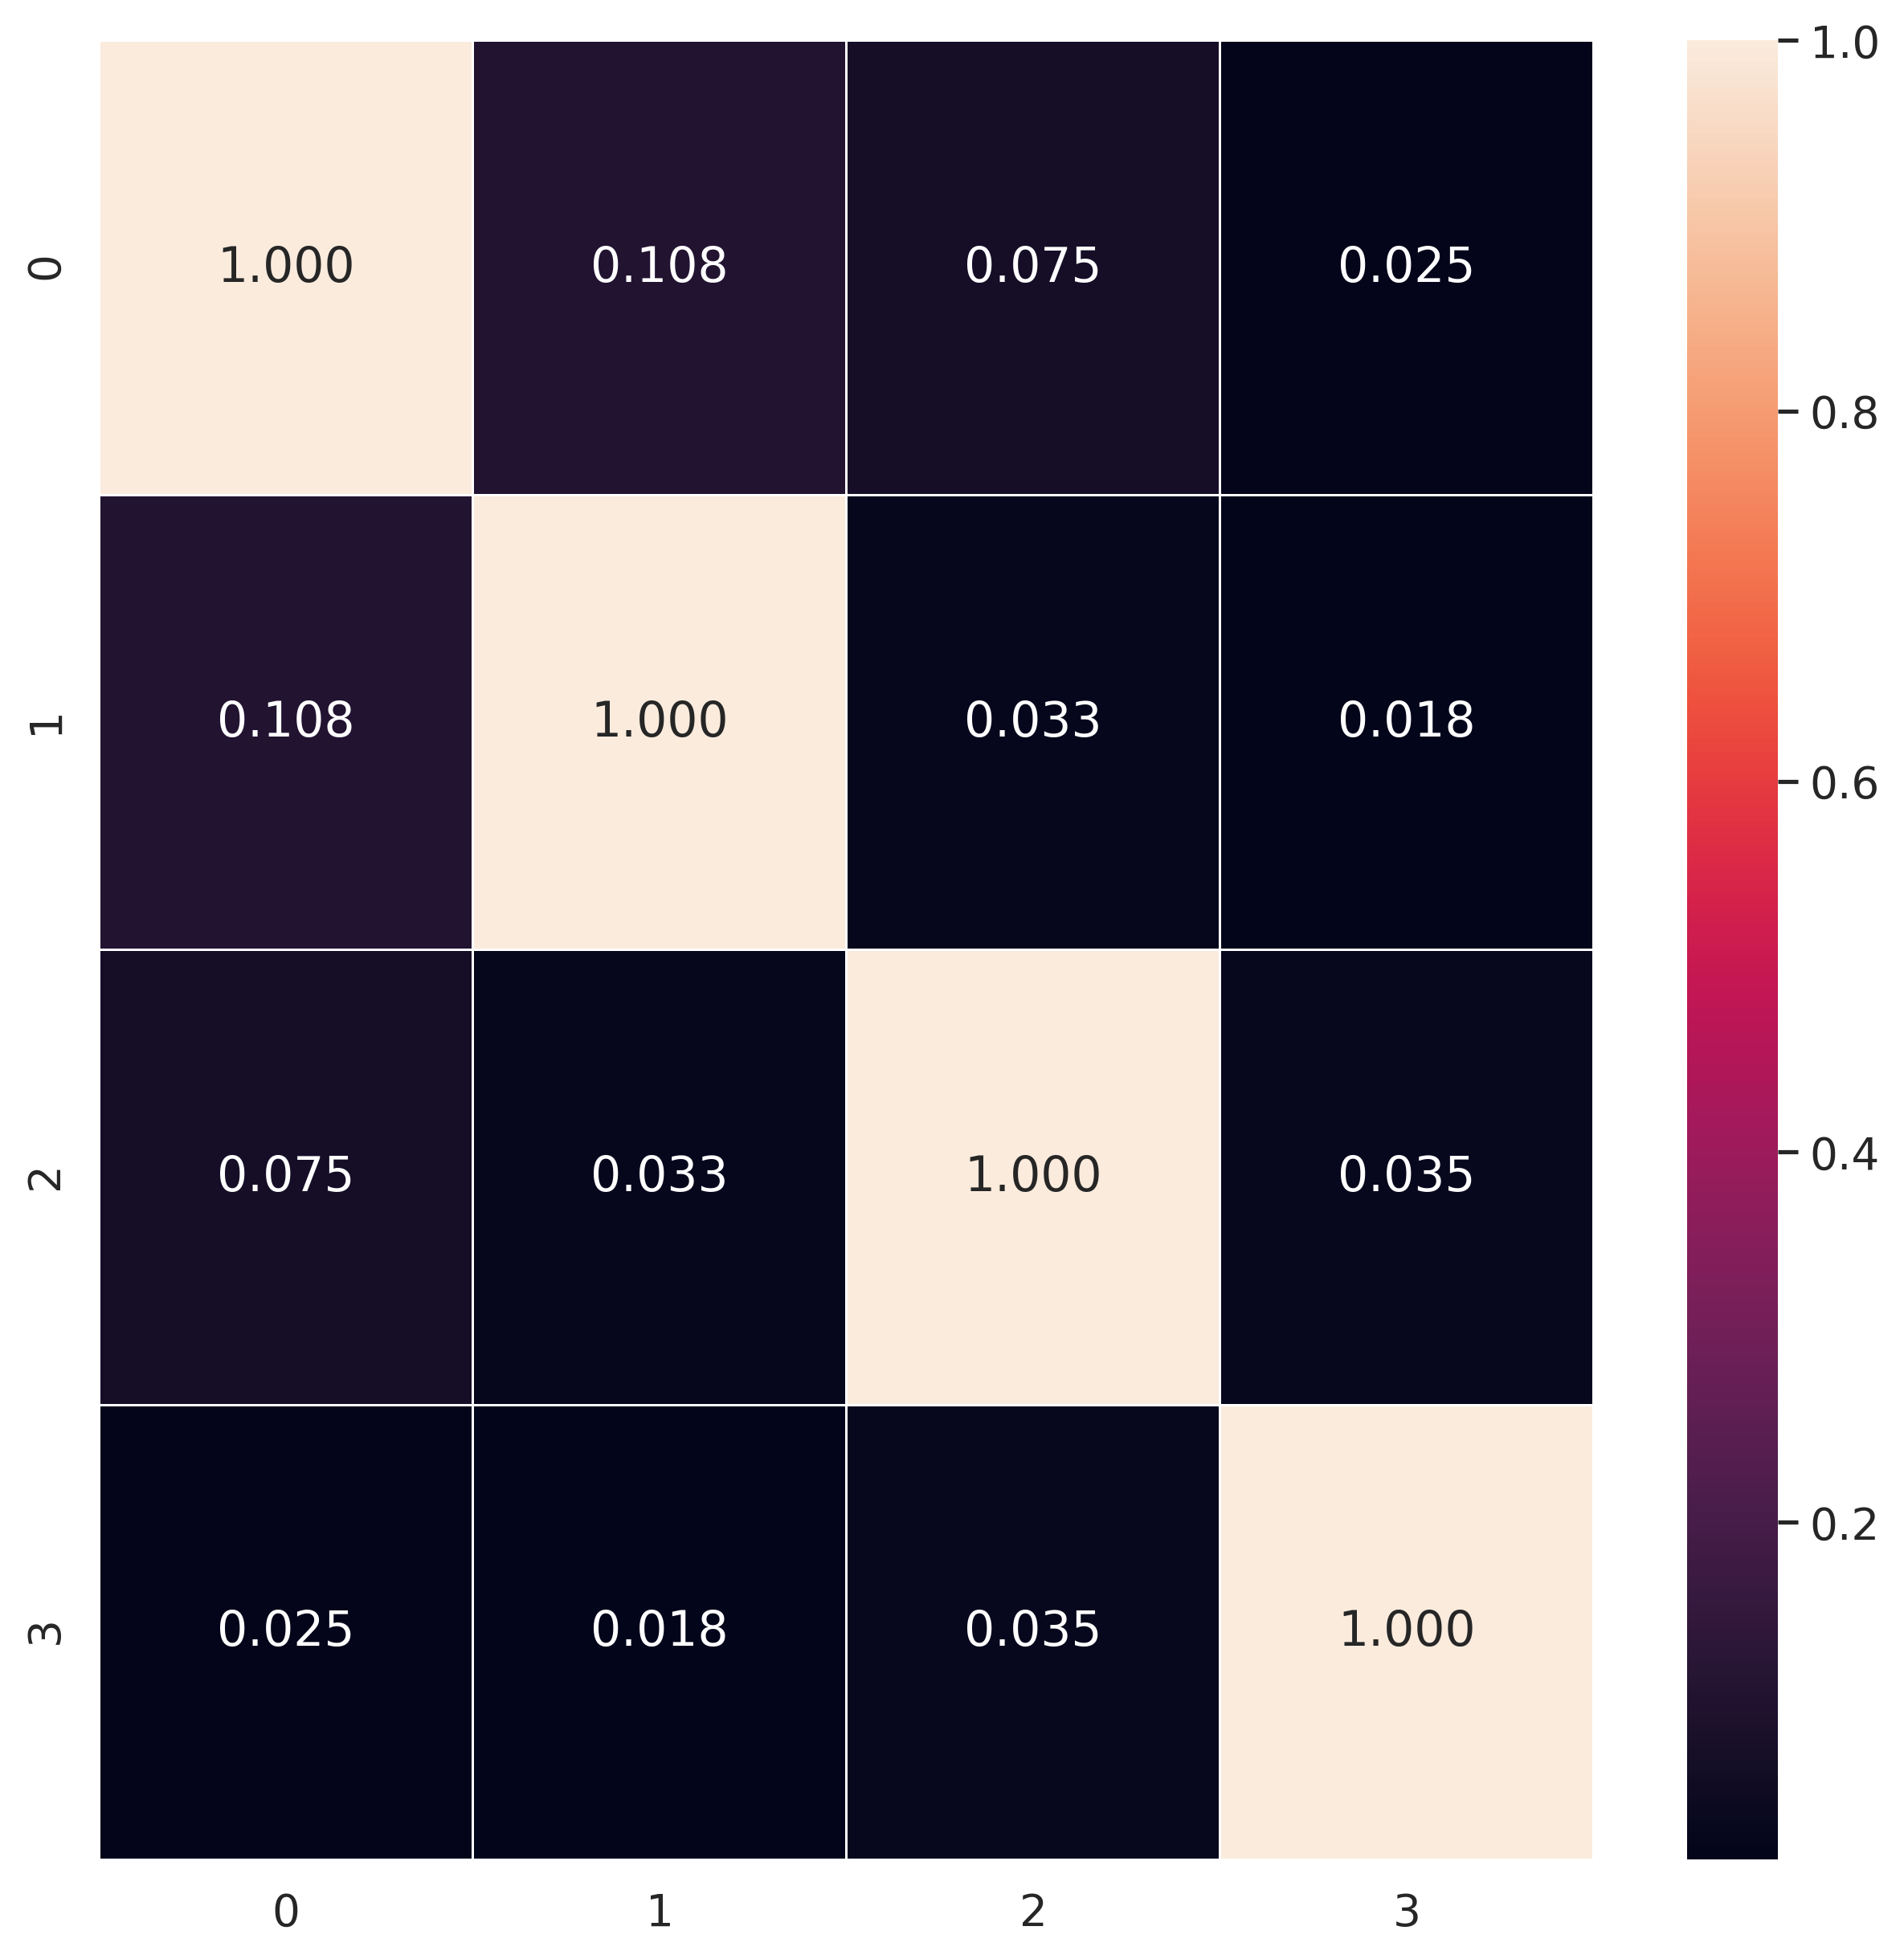

In [57]:
comparisons = compare_age_similarity(all_ages_s, bin_1_s, bin_2_s, bin_3_s, calc_cosine_similarity)
np.fill_diagonal(comparisons, 1)
print(comparisons)
plot_age_comparisons(comparisons)

In [51]:
distance_func = stats.spearmanr

print(distance_func(all_ages, bin_1))
print(distance_func(all_ages, bin_2))
print(distance_func(all_ages, bin_3))
print(distance_func(bin_1, bin_2))
print(distance_func(bin_1, bin_3))
print(distance_func(bin_2, bin_3))

SpearmanrResult(correlation=0.04839780724742265, pvalue=1.8375564055331053e-19)
SpearmanrResult(correlation=0.06770822451095877, pvalue=1.4502789570195166e-36)
SpearmanrResult(correlation=0.02549822337249106, pvalue=2.019240964563468e-06)
SpearmanrResult(correlation=0.011898695973375492, pvalue=0.02662370222138213)
SpearmanrResult(correlation=0.0055914921018586205, pvalue=0.2975089091639709)
SpearmanrResult(correlation=0.003062358126750857, pvalue=0.5682935956922676)
